# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

import math

# Simulator

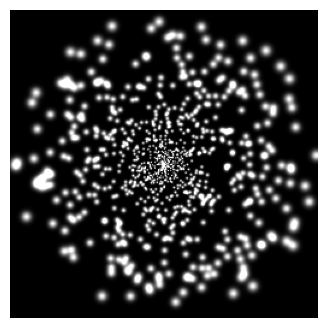

In [3]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.figure(figsize=(4, 4))
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Optimization with ML

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import torch.nn as nn

import tqdm

import piq

# clear output
from IPython.display import clear_output

In [5]:
def visualize_sample(images, phosphenes, epoch, step, losses=None, stimulation=None):
    """Visualize the first image in the batch and its corresponding phosphene output."""

    to_show = [images, phosphenes]
    if losses is not None:
        to_show.append(losses)
    if stimulation is not None:
        to_show.append(stimulation)

    plt.figure(figsize=(15, 5))
    for i, tensor in enumerate(to_show):
        plt.subplot(1, len(to_show), i+1)
        if i == 0:
            # Natural image: convert from (C,H,W) to (H,W,C)
            image = tensor[0]
            image = (image - image.min()) / (image.max() - image.min())
            plt.imshow(image.cpu().detach().numpy(), cmap='gray')
            plt.axis('off')
            plt.title(f'Input Image\n(Epoch {epoch}, Step {step})')
        elif i == 1:
            plt.imshow(tensor.cpu().detach().numpy(), cmap='gray')
            plt.axis('off')
            plt.title(f'Output Phosphene Image\n(Epoch {epoch}, Step {step})')
        elif i == 2:
            plt.plot(tensor)
            plt.xlabel('Step')
            plt.ylabel('Loss')
            plt.title('Loss history')
        elif i == 3:
            plt.imshow(tensor.cpu().detach().numpy(), cmap='gray', vmin=image.min(), vmax=image.max())
            plt.axis('off')
            plt.title(f'Stimulation\n(Epoch {epoch}, Step {step})')
    plt.tight_layout()
    plt.show()

In [6]:
def convlayer(n_input, n_output, k_size=3, stride=1, padding=1, resample_out=None):
    layer = [
        nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(inplace=True),
        resample_out]
    if resample_out is None:
        layer.pop()
    return layer

class ResidualBlock(nn.Module):
    def __init__(self, n_channels, stride=1, resample_out=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.LeakyReLU(inplace=False)
        self.conv2 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n_channels)
        self.resample_out = resample_out

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        if self.resample_out:
            out = self.resample_out(out)
        return out

class E2E_Encoder(nn.Module):
    """
    Simple non-generic encoder class that receives 128x128 input and outputs 32x32 feature map as stimulation protocol
    """
    def __init__(self, in_channels=3, out_channels=1, n_electrodes=1024, out_scaling=1e-4, out_activation='relu', flattened_feature_size=1024):
        super(E2E_Encoder, self).__init__()
        self.output_scaling = out_scaling
        self.out_activation = {'tanh': nn.Tanh(), ## NOTE: simulator expects only positive stimulation values 
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.ReLU(),
                               'softmax':nn.Softmax(dim=1)}[out_activation]

        # Model
        self.model = nn.Sequential(*convlayer(in_channels,8,3,1,1),
                                   *convlayer(8,16,3,1,1,resample_out=nn.MaxPool2d(2)),
                                   *convlayer(16,32,3,1,1,resample_out=nn.MaxPool2d(2)),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   *convlayer(32,16,3,1,1),
                                   nn.Conv2d(16,1,3,1,1),
                                   nn.Flatten(),
                                   nn.Linear(flattened_feature_size, n_electrodes),
                                   self.out_activation)

    def forward(self, x):
        self.out = self.model(x)
        stimulation = self.out*self.output_scaling #scaling improves numerical stability
        return stimulation

In [7]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 4
num_epochs = 5
out_channels = 1
n_electrodes = 1024
amplitude = params['sampling']['stimulus_scale']
flattened_feature_size = 1024 * 4  # for the encoder
# Set the output dimension of the learned feature extractor.
learned_feature_dim = 128
lambda_mi = 1.0    # weight for MI loss

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
    ])

# dataset = datasets.Imagenette(root='../../data', transform=transform, download=False)
dataset = datasets.MNIST(root='../../data', transform=transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
params['run']['batch_size'] = batch_size
simulator = PhospheneSimulator(params, phosphene_coords)

torch.use_deterministic_algorithms(False)

in_channels = 1 if dataset[0][0].shape[0] == 1 else 3

# MINE

In [8]:
# -----------------------------
# 2. Define the MINE Network
# -----------------------------
# The MINE network estimates a lower bound on MI between two feature vectors.
class MINE(nn.Module):
    def __init__(self, feature_dim):
        super(MINE, self).__init__()
        self.fc1 = nn.Linear(feature_dim * 2, 256)
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
    def forward(self, x, y):
        # Concatenate the two feature vectors.
        combined = torch.cat([x, y], dim=1)
        h = self.relu(self.fc1(combined))
        return self.fc2(h)

# -----------------------------
# 3. Define a Learned Feature Extractor
# -----------------------------
# Instead of flattening, we use a CNN that outputs a lower-dimensional feature vector.
class FeatureExtractor(nn.Module):
    def __init__(self, output_dim=128):
        super(FeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # [B,16,128,128]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [B,32,64,64]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [B,64,32,32]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # [B,128,16,16]
            nn.ReLU()
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, output_dim)
    def forward(self, x):
        features = self.conv_layers(x)
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features

In [9]:
# encoder = E2E_Encoder(
#     in_channels=in_channels, 
#     out_channels=1, 
#     n_electrodes=n_electrodes, 
#     out_scaling=amplitude, 
#     out_activation='sigmoid', 
#     flattened_feature_size=flattened_feature_size
# ).to(device)

# # Instantiate the learned feature extractor.
# feature_extractor = FeatureExtractor(output_dim=learned_feature_dim).to(device)

# # Instantiate the MINE network using the learned feature dimension.
# mine_net = MINE(feature_dim=learned_feature_dim).to(device)

# # Create optimizers. We'll use separate optimizers for each module.
# optimizer_encoder = optim.Adam(encoder.parameters(), lr=1e-4)
# optimizer_feat = optim.Adam(feature_extractor.parameters(), lr=1e-4)
# optimizer_mine = optim.Adam(mine_net.parameters(), lr=1e-4)

# torch.use_deterministic_algorithms(False)

# losses = []

# # -----------------------------
# # 7. Training Loop: Optimize via MI Loss
# # -----------------------------
# for epoch in range(num_epochs):
#     encoder.train()
#     feature_extractor.train()
#     mine_net.train()
#     running_loss = 0.0

#     i = 0
#     for images, _ in tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         images = images.to(device)

#         # Step 1: Pass the original images through the encoder to get stimulation signals.
#         stim = encoder(images)

#         # Step 2: Generate phosphene representations using the simulator.
#         simulator.reset()  # Reset simulator state if needed.
#         phosphenes = simulator(stim).unsqueeze(1)  # Expected shape: [batch, 1, H, W]

#         # Step 3: Extract features using the learned feature extractor.
#         orig_features = feature_extractor(images)      # shape: [batch, learned_feature_dim]
#         phos_features = feature_extractor(phosphenes)    # same shape as orig_features

#         # Step 4: Estimate MI using the MINE network.
#         # a. Compute output on joint (true) pairs.
#         T_joint = mine_net(orig_features, phos_features)
#         # b. Compute output on marginal (shuffled) pairs.
#         idx = torch.randperm(images.size(0))
#         T_marginal = mine_net(orig_features, phos_features[idx])
        
#         # Compute the MI lower bound estimate.
#         E_joint = torch.mean(T_joint)
#         E_marginal = torch.mean(torch.exp(T_marginal))
#         mi_estimate = E_joint - torch.log(E_marginal + 1e-10)
#         # Our loss is the negative MI (we want to maximize MI).
#         mi_loss = -mi_estimate

#         total_loss = lambda_mi * mi_loss

#         # Step 5: Backpropagate and update all networks.
#         optimizer_encoder.zero_grad()
#         optimizer_feat.zero_grad()
#         optimizer_mine.zero_grad()
#         total_loss.backward()
#         optimizer_encoder.step()
#         optimizer_feat.step()
#         optimizer_mine.step()

#         running_loss += total_loss.item()
#         losses.append(total_loss.item())

#         if i % 100 == 0:
#             clear_output(wait=True)
#             visualize_sample(images, phosphenes, epoch+1, i, losses=losses, stimulation=stim)
#         i += 1

#     avg_loss = running_loss / len(dataloader)
#     print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

# print("Training complete.")

# CLUB

In [10]:
torch.autograd.set_detect_anomaly(True)


# ----------------------------------------------------------------------------
# 1. Representation Network: Transform image -> electrode_vector (stimulation)
# ----------------------------------------------------------------------------
# The output is an image of shape (B, 1, 256, 256)
class RepresentationNetwork(nn.Module):
    def __init__(self, in_channels):
        super(RepresentationNetwork, self).__init__()
        self.conv = nn.Sequential(
            # Maintain resolution: stride=1, padding chosen to preserve dimensions.
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),  # (B,16,256,256)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),           # (B,32,256,256)
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),           # (B,16,256,256)
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),            # (B,1,256,256)
            nn.Sigmoid()  # assume stimulation values in [0,1]
        )
        
    def forward(self, x):
        s = self.conv(x)
        return s # shape: (B, 1, 256, 256)
    
class CLUBConditional(nn.Module):
    def __init__(self, image_channels, hidden_channels=16):
        super(CLUBConditional, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(image_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, 2, kernel_size=3, stride=1, padding=1)  # 2 output channels: one for mu, one for logvar
        )
        
    def forward(self, x):
        # x: [B, C, H, W] (typically the input image)
        out = self.conv(x)  # [B, 2, 256, 256]
        mu = out[:, 0:1, :, :]    # [B,1,256,256]
        logvar = out[:, 1:2, :, :]  # [B,1,256,256]
        return mu, logvar
    
    @staticmethod
    def log_gaussian_prob(s, mu, logvar, eps=1e-10):
        """
        s, mu, logvar: each of shape [B, 1, H, W]
        Compute log probability per sample, summing over the spatial dimensions.
        Returns: tensor of shape [B]
        """
        # Using the formula for the log of a Gaussian:
        # log N(s; mu, sigma^2) = -0.5 * [ (s-mu)^2/sigma^2 + log(2*pi*sigma^2) ]
        p = -0.5 * (((s - mu) ** 2) / (torch.exp(logvar) + eps) + logvar + torch.log(torch.tensor(2 * 3.141592653589793)))
        return p.view(p.size(0), -1).sum(dim=1)
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4
num_epochs = 5

# Use MNIST resized to 256x256 for example.
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])
dataset = datasets.MNIST(root='../../data', transform=transform, download=False)
# dataset = datasets.Imagenette(root='../../data', transform=transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

in_channels = 1 if dataset[0][0].shape[0] == 1 else 3

# Our learned representation network outputs a stimulation of shape (B,1,256,256).
rep_net = RepresentationNetwork(in_channels=in_channels).to(device)
# The simulator remains untouched.
params['run']['batch_size'] = batch_size
simulator = PhospheneSimulator(params, phosphene_coords)
# CLUB conditional network takes the input image (e.g., MNIST image) and produces parameters for a Gaussian over s.
club_net = CLUBConditional(image_channels=1, hidden_channels=16).to(device)
club_net_phosphenes = CLUBConditional(image_channels=1, hidden_channels=16).to(device)

# We optimize the representation network and the CLUB network.
optimizer_rep = optim.Adam(rep_net.parameters(), lr=1e-4)
optimizer_club = optim.Adam(club_net.parameters(), lr=1e-4)
optimizer_club_phosphenes = optim.Adam(club_net_phosphenes.parameters(), lr=1e-4)

def club_loss(club_net, images, s):
    """
    Computes the CLUB objective for a batch.
      images: [B, C, H, W] - input images.
      s: [B, 1, 256, 256] - electrode_vector (stimulation) from the representation network.
    Returns:
      CLUB objective (to be maximized), so we minimize its negative.
    """
    mu, logvar = club_net(images)  # each of shape [B, 1, 256, 256]
    log_joint = CLUBConditional.log_gaussian_prob(s, mu, logvar)  # shape: [B]
    E_joint = torch.mean(log_joint)
    
    # For negative pairs, shuffle s along the batch dimension.
    idx = torch.randperm(s.size(0))
    s_shuffled = s[idx]
    log_marginal = CLUBConditional.log_gaussian_prob(s_shuffled, mu, logvar)
    E_marginal = torch.mean(log_marginal)
    
    club_obj = E_joint - E_marginal
    return club_obj

# Our learned representation network outputs a stimulation of shape (B,1,256,256).
rep_net = RepresentationNetwork(in_channels=in_channels).to(device)
# The simulator remains untouched.
params['run']['batch_size'] = batch_size
simulator = PhospheneSimulator(params, phosphene_coords)
# CLUB conditional network takes the input image (e.g., MNIST image) and produces parameters for a Gaussian over s.
club_net = CLUBConditional(image_channels=in_channels, hidden_channels=16).to(device)

# We optimize the representation network and the CLUB network.
optimizer_rep = optim.Adam(rep_net.parameters(), lr=1e-4)
optimizer_club = optim.Adam(club_net.parameters(), lr=1e-4)

def club_loss(club_net, images, s):
    """
    Computes the CLUB objective for a batch.
      images: [B, C, H, W] - input images.
      s: [B, 1, 256, 256] - electrode_vector (stimulation) from the representation network.
    Returns:
      CLUB objective (to be maximized), so we minimize its negative.
    """
    mu, logvar = club_net(images)  # each of shape [B, 1, 256, 256]
    # clamp logvar to avoid numerical instability
    logvar = torch.clamp(logvar, min=-0.05, max=0.05)
    mu = torch.clamp(mu, min=0.0, max=1.0)
    log_joint = CLUBConditional.log_gaussian_prob(s, mu, logvar)  # shape: [B]
    E_joint = torch.mean(log_joint)
    
    # For negative pairs, shuffle s along the batch dimension.
    idx = torch.randperm(s.size(0))
    s_shuffled = s[idx]
    log_marginal = CLUBConditional.log_gaussian_prob(s_shuffled, mu, logvar)
    E_marginal = torch.mean(log_marginal)
    
    club_obj = E_joint - E_marginal
    return club_obj


# # ----------------------------------------------------------------------------
# # 7. Training Loop
# # ----------------------------------------------------------------------------
# # Here we learn the representation by maximizing the mutual information between the
# # input image and the learned stimulation. Since optimizers minimize loss,
# # we minimize the negative CLUB objective.
# losses = []
# for epoch in range(num_epochs):
#     rep_net.train()
#     club_net.train()
#     running_loss = 0.0

#     i = 0
#     for images, _ in tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         images = images.to(device)
        
#         # Obtain the learned stimulation representation (electrode_vector) of shape (B,1,256,256)
#         stimulus = rep_net(images)
        
#         # Optionally, generate the phosphene percept (simulator remains fixed)
#         simulator.reset()
#         electrode_vector = simulator.sample_stimulus(stimulus, rescale=True)
#         phosphenes = simulator(electrode_vector)
        
#         # Compute CLUB objective for (image, electrode_vector) pairs.
#         # club_obj = club_loss(club_net, images, stimulus)
#         # club_obj_phosphenes = club_loss(club_net_phosphenes, phosphenes.unsqueeze(1), stimulus)
#         club_obj = club_loss(club_net, phosphenes.unsqueeze(1), images.mean(dim=1, keepdim=True))
#         # club_obj = club_loss(club_net, images, stimulus)
#         # Since we want to maximize MI, we minimize the negative CLUB objective.
#         loss = - (club_obj)
        
#         optimizer_rep.zero_grad()
#         optimizer_club.zero_grad()
#         optimizer_club_phosphenes.zero_grad()
#         loss.backward()
#         optimizer_rep.step()
#         optimizer_club.step()
#         optimizer_club_phosphenes.step()
        
#         running_loss += loss.item()
#         losses.append(loss.item())

#         if i % 100 == 0:
#             clear_output(wait=True)
#             visualize_sample(images[0], phosphenes[0], epoch+1, i, losses=losses, stimulation=stimulus[0][0])

#         i += 1
        
#     avg_loss = running_loss / len(dataloader)
#     print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

# print("Training complete.")

In [11]:
# club_obj = club_loss(club_net, phosphenes.unsqueeze(1), images.mean(dim=1, keepdim=True))
# club_obj

# InfoNCE

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.use_deterministic_algorithms(False)

class InfoNCE(nn.Module):
    def __init__(self, temperature=0.07):
        super(InfoNCE, self).__init__()
        self.temperature = temperature

    def forward(self, query, key):
        """
        query: [B, C, H, W] tensor (e.g., processed phosphenes)
        key:   [B, C, H, W] tensor (e.g., processed images, or their summaries)
        
        The idea is to produce embeddings (or summaries) for each modality. Here we assume
        the network producing these embeddings has already been applied. If the outputs are 
        2D (i.e. per-pixel), you may want to pool them spatially.
        
        For InfoNCE, we compute the cosine similarity (or dot-product) between query and key
        pairs, then for each example, treat its corresponding pair as positive, and all others
        as negatives.
        """
        B = query.size(0)
        # Optionally pool spatial dimensions if your embeddings are 2D maps:
        query_embed = F.adaptive_avg_pool2d(query, (1,1)).view(B, -1)  # [B, C]
        key_embed   = F.adaptive_avg_pool2d(key, (1,1)).view(B, -1)      # [B, C]

        # Normalize the embeddings (so that cosine similarity = dot product)
        query_embed = F.normalize(query_embed, dim=1)
        key_embed   = F.normalize(key_embed, dim=1)

        # Compute similarity matrix [B, B]: each row i is compared against all keys j
        logits = torch.matmul(query_embed, key_embed.t())  # cosine similarity
        logits /= self.temperature

        # Labels: positive sample for each query is at the diagonal (i.e., index i)
        labels = torch.arange(B, device=logits.device)

        # Cross-entropy loss: we want the highest similarity for the matching pair
        loss = F.cross_entropy(logits, labels)
        return loss

# Example usage:
# Assume we have outputs from your networks:
# For instance, let phosphenes and images be your two modalities.
# In your training loop, you might do:

# Suppose:
# phosphenes: [B, 1, 256, 256]  (from your simulator)
# images: [B, 1, 256, 256]       (or maybe images.mean(dim=1, keepdim=True) if appropriate)

info_nce_loss_fn = InfoNCE(temperature=0.07)

# Here you might want to process or embed each modality further:
# For simplicity, let's assume you already have features from your networks:
# For example, using a simple convolutional head (or even a linear projection after pooling)
# that maps each modality to an embedding space.

# We'll define a simple projector:
class Projector(nn.Module):
    def __init__(self, in_channels, emb_dim=128):
        super(Projector, self).__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(32, emb_dim)
        )
    def forward(self, x):
        return self.proj(x)

# # Instantiate projectors for each modality:
# projector_phos = Projector(in_channels=1, emb_dim=128).to(device)
# projector_img  = Projector(in_channels=1, emb_dim=128).to(device)

# # In your training loop, after getting phosphenes and images:
# # (For example, images might be preprocessed differently if needed.)
# phos_embed = projector_phos(phosphenes)  # [B, 128]
# img_embed  = projector_img(images.mean(dim=1, keepdim=True))  # [B, 128]

# # We need to reshape these to [B, C, 1, 1] for InfoNCE loss,
# # but since they are already vectors, we can simply unsqueeze spatial dims:
# phos_embed = phos_embed.unsqueeze(-1).unsqueeze(-1)  # [B, 128, 1, 1]
# img_embed  = img_embed.unsqueeze(-1).unsqueeze(-1)    # [B, 128, 1, 1]

# # Now compute InfoNCE loss:
# loss_info_nce = info_nce_loss_fn(phos_embed, img_embed)

# print("InfoNCE loss:", loss_info_nce)


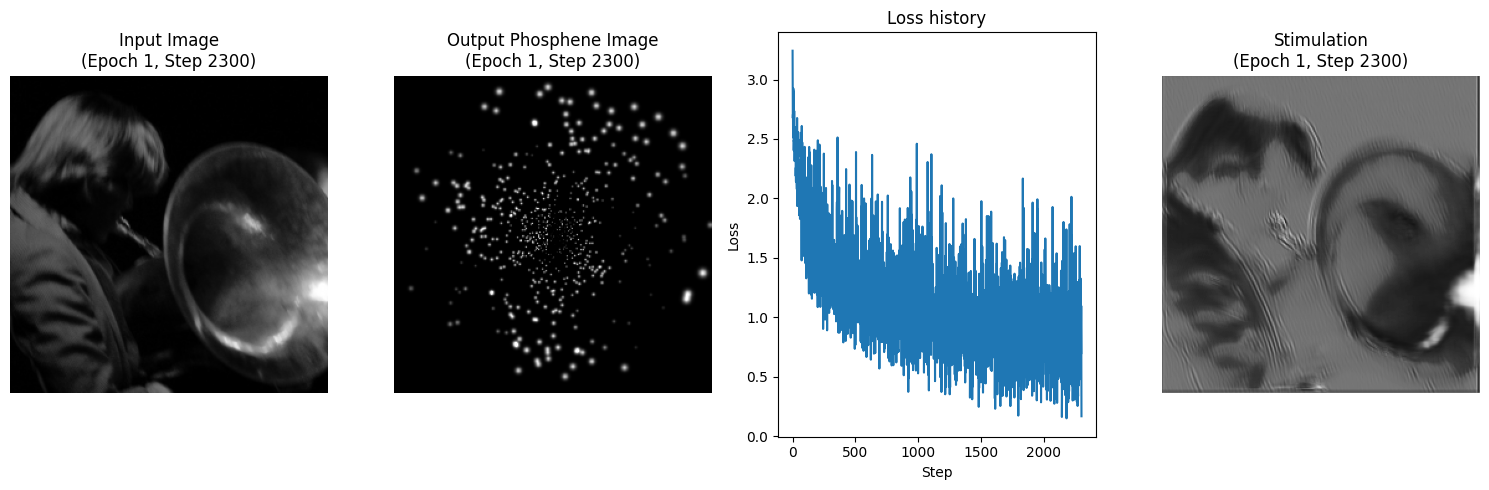

Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2367/2368 [03:09<00:00, 12.52it/s]


RuntimeError: shape '[4, 1024, 1, 1]' is invalid for input of size 1024

In [17]:
torch.autograd.set_detect_anomaly(True)

# ----------------------------------------------------------------------------
# 1. Representation Network: Transform image -> electrode_vector (stimulation)
# ----------------------------------------------------------------------------
# The output is an image of shape (B, 1, 256, 256)
class RepresentationNetwork(nn.Module):
    def __init__(self, in_channels):
        super(RepresentationNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=7, stride=1, padding=3),  # (B,16,256,256)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),           # (B,32,256,256)
            nn.Sigmoid()  # assume stimulation values in [0,1]
        )
        
    def forward(self, x):
        s = self.conv(x)
        return s # shape: (B, 1, 256, 256)

# -------------------------------
# 1. Define the InfoNCE Loss Module
# -------------------------------
class InfoNCE(nn.Module):
    def __init__(self, temperature=0.01):
        super(InfoNCE, self).__init__()
        self.temperature = temperature

    def forward(self, query, key):
        """
        query: [B, C, H, W] tensor (e.g., projected phosphene embeddings)
        key:   [B, C, H, W] tensor (e.g., projected image embeddings)
        """
        B = query.size(0)
        # Pool spatial dimensions and flatten to [B, C]
        query_embed = F.adaptive_avg_pool2d(query, (1, 1)).view(B, -1)
        key_embed   = F.adaptive_avg_pool2d(key, (1, 1)).view(B, -1)
        # Normalize embeddings (cosine similarity is then dot-product)
        query_embed = F.normalize(query_embed, dim=1)
        key_embed   = F.normalize(key_embed, dim=1)
        # Compute similarity matrix and scale by temperature
        logits = torch.matmul(query_embed, key_embed.t()) / self.temperature
        # For each query, the positive key is the one at the same index
        labels = torch.arange(B, device=logits.device)
        loss = F.cross_entropy(logits, labels)
        return loss

# -------------------------------
# 2. Define a Simple Projection Head
# ------------------------------
class Projector(nn.Module):
    def __init__(self, in_channels, emb_dim=128):
        super(Projector, self).__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(32, emb_dim)
        )
    def forward(self, x):
        return self.proj(x)


# -------------------------------
# 3. Instantiate Modules and Optimizers
# -------------------------------
# Assumptions:
#   - rep_net is your representation network (input image -> stimulation), already defined.
#   - simulator is your simulation module that produces phosphenes from stimulation.
#   - dataloader provides images from (for example) MNIST, preprocessed to [B, 1, 256, 256].
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the InfoNCE loss
info_nce_loss_fn = InfoNCE(temperature=0.07).to(device)

dataset = datasets.Imagenette(root='../../data', transform=transform, download=False)
# dataset = datasets.MNIST(root='../../data', transform=transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

params['run']['batch_size'] = batch_size
simulator = PhospheneSimulator(params, phosphene_coords)

# encoder = E2E_Encoder(in_channels=in_channels, out_channels=1, n_electrodes=n_electrodes, out_scaling=amplitude, out_activation='sigmoid', flattened_feature_size=flattened_feature_size).to(device)

# Instantiate projector networks for each modality (phosphenes and images)
projector_phos = Projector(in_channels=1, emb_dim=128).to(device)
projector_img  = Projector(in_channels=1, emb_dim=128).to(device)
projector_stim = Projector(in_channels=1, emb_dim=128).to(device)

rep_net = RepresentationNetwork(in_channels=1).to(device)

# Optimizers for the representation network and the projectors
optimizer_rep      = optim.Adam(rep_net.parameters(), lr=5e-4)
optimizer_proj_phos = optim.Adam(projector_phos.parameters(), lr=5e-5)
optimizer_proj_img  = optim.Adam(projector_img.parameters(), lr=5e-5)
optimizer_proj_stim = optim.Adam(projector_stim.parameters(), lr=5e-5)
# optimizer_encoder = optim.Adam(encoder.parameters(), lr=1e-4)

num_epochs = 5  # adjust as needed
losses = []


torch.use_deterministic_algorithms(False)
# clip gradients

# -------------------------------
# 4. Training Loop Using InfoNCE
# -------------------------------
for epoch in range(num_epochs):
    rep_net.train()
    projector_phos.train()
    projector_img.train()
    projector_stim.train()
    # encoder.train()
    running_loss = 0.0

    i = 0
    for images, _ in tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        images = images.mean(dim=1, keepdim=True)  # assume grayscale images
        
        # Generate the stimulation from the representation network.
        # Expected shape: [B, 1, 256, 256]
        stimulus = rep_net(images)
        
        # electrode_vector = encoder(images)
        
        # Run the simulator to obtain phosphenes.
        # Ensure the simulator is reset if necessary.
        simulator.reset()
        electrode_vector = simulator.sample_stimulus(stimulus, rescale=True)
        
        # Assume phosphenes output has shape [B, 1, 256, 256]
        phosphenes = simulator(electrode_vector).unsqueeze(1)
        phosphenes_to_show = phosphenes.clone()
        
        # Compute the embeddings for each modality via the projector networks.
        # The projector expects input of shape [B, in_channels, H, W]
        phos_embedding = projector_phos(phosphenes)
        stim_embedding = projector_stim(stimulus)
        img_embedding  = projector_img(images)
        
        # The InfoNCE loss module expects 4D tensors.
        # Reshape the embeddings from [B, emb_dim] to [B, emb_dim, 1, 1]
        phos_embedding = phos_embedding.unsqueeze(-1).unsqueeze(-1)
        img_embedding  = img_embedding.unsqueeze(-1).unsqueeze(-1)
        stim_embedding = stim_embedding.unsqueeze(-1).unsqueeze(-1)
        
        # Compute the InfoNCE loss between the two modalities
        # loss = info_nce_loss_fn(phos_embedding, img_embedding)
        loss = info_nce_loss_fn(phos_embedding, stim_embedding) + info_nce_loss_fn(img_embedding, stim_embedding)
        
        # Backpropagation: update the representation network and both projectors.
        optimizer_rep.zero_grad()
        optimizer_proj_phos.zero_grad()
        optimizer_proj_img.zero_grad()
        optimizer_proj_stim.zero_grad()
        # optimizer_encoder.zero_grad()
        loss.backward()
        # optimizer_encoder.step()
        optimizer_rep.step()
        optimizer_proj_phos.step()
        optimizer_proj_img.step()
        optimizer_proj_stim.step()
        
        running_loss += loss.item()
        losses.append(loss.item())

        if i % 100 == 0:
            clear_output(wait=True)
            visualize_sample(images[0], phosphenes_to_show[0][0], epoch+1, i, losses=losses, stimulation=stimulus[0][0])

        i += 1
    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

print("Training complete.")

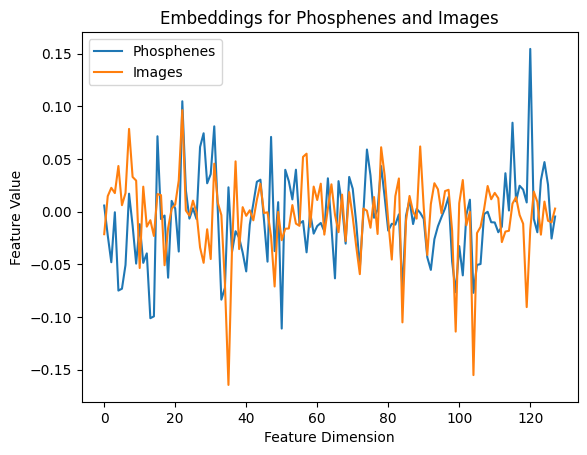

In [14]:
plt.plot(phos_embedding[0].squeeze().detach().cpu().numpy())
plt.plot(img_embedding[0].squeeze().detach().cpu().numpy())
plt.legend(['Phosphenes', 'Images'])
plt.xlabel('Feature Dimension')
plt.ylabel('Feature Value')
plt.title('Embeddings for Phosphenes and Images')
plt.show()